In [413]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functions as util
from sklearn.preprocessing import OneHotEncoder
import math
import pickle
import scipy.io as sio

In [414]:
def LoadBatch(filename):
    with open('Dataset/'+filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [415]:
def one_hot(labels):
    unique_val=np.unique(labels)
    #display(labels)
    encoded=np.zeros((np.shape(labels)[0],np.shape(unique_val)[0]))
    for idx, val in enumerate(labels):
        encoded[idx][val] = 1
    return encoded
        
        

In [438]:
def loading_batch(filename):
    dict_data=LoadBatch(filename)
    data=(dict_data[b'data'].T/255)# of shape d*n where rows are the dimensionsionality cols are the images
    labels=(dict_data[b'labels'])# list of labels for each image in training
    encoded_labels=one_hot(labels).T#one hot encode list of labels of training data 10*n
    return data,labels,encoded_labels
    

In [439]:
X,y,Y=loading_batch('data_batch_1')
batches = LoadBatch('cifar-10-batches-py/batches.meta')
labels = [label_name.decode('utf-8') for label_name in batches[b'label_names']]

In [440]:
Xval,yval,Yval=loading_batch('data_batch_2')
Xtest,ytest,Ytest = loading_batch('test_batch')

In [441]:
def second_task(trainX,trainZ=None):
    if(trainZ is None):
        mean_X =trainX.mean(axis=1)

        std_X=trainX.std(axis=1)

        X=trainX-mean_X[:,None]

        X=X/std_X[:,None]
        return X
    else:
        mean_X =trainX.mean(axis=1)
        std_X=trainX.std(axis=1)
        Z=trainZ-mean_X[:,None]
        Z=Z/std_X[:,None]
        return Z
        
        

In [442]:
X=second_task(X)
Xval=second_task(X,Xval)
Xtest=second_task(X,Xtest)#mean and sd normalization

In [443]:
def third_task(K,d):
    np.random.seed(0)
    W = np.random.normal(size=(K, d), loc=0, scale=.01)#rnd no of class labels *  dimensionality
    np.random.seed(0)
    b = np.random.normal(size=(K, 1), loc=0, scale=.01)#rnd no of class labels * 1 column
    return W,b
    

In [444]:
W,b=third_task(10,X.shape[0])

In [445]:
def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [446]:
def fourth_task(X,W,b):
    """P=np.dot(W,X)
    P=P+b"""
    S = W@X+b
    P = softmax(S)
    return P

In [447]:
def ComputeCost(X,Y,W,b,lambdaX):
    
    
    P=fourth_task(X,W,b)

    """ lcr=sum(-np.log((Y*P).sum(axis=0))) """
    lcr=-np.sum(np.multiply(Y,np.log(P)))
    Reg_term=lambdaX*((W**2).sum())
    J=lcr/X.shape[1]+Reg_term
    return J
    

In [448]:
def ComputeAccuracy(X,y,W,b):
    P=fourth_task(X,W,b)
    acc=np.mean(y==np.argmax(P,axis=0))
    return acc
    

In [449]:
def ComputeGradsNum(X, Y, P, W, b, lamda, h):
    no = W.shape[0]
    d = X.shape[0]
    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));

    c = ComputeCost(X, Y, W, b, lamda);
    
    
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] += h
        c2 = ComputeCost(X, Y, W, b_try, lamda)
        
        grad_b[i] = (c2-c) / h

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.array(W)
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lamda)
            grad_W[i,j] = (c2-c) / h
            

    return [grad_W, grad_b]

In [450]:
def ComputeGradsNumSlow(X, Y, P, W, b, lamda, h):
	""" Converted from matlab code """
	no 	= 	W.shape[0]
	d 	= 	X.shape[0]

	grad_W = np.zeros(W.shape);
	grad_b = np.zeros((no, 1));
	
	for i in range(len(b)):
		b_try = np.array(b)
		b_try[i] -= h
		c1 = ComputeCost(X, Y, W, b_try, lamda)

		b_try = np.array(b)
		b_try[i] += h
		c2 = ComputeCost(X, Y, W, b_try, lamda)

		grad_b[i] = (c2-c1) / (2*h)

	for i in range(W.shape[0]):
		for j in range(W.shape[1]):
			W_try = np.array(W)
			W_try[i,j] -= h
			c1 = ComputeCost(X, Y, W_try, b, lamda)

			W_try = np.array(W)
			W_try[i,j] += h
			c2 = ComputeCost(X, Y, W_try, b, lamda)

			grad_W[i,j] = (c2-c1) / (2*h)

	return [grad_W, grad_b]


In [451]:
def ComputeGradients(X,Y,P,W,b,lambdaX):
    n=X.shape[1]
    C = Y.shape[0]
    G=-(Y-P)
    grad_W=np.dot(G,X.T)/n+2*lambdaX*W
    
    grad_b=(np.dot(G,np.ones(shape=(n,1)))/n).reshape(C,1)
    return grad_W,grad_b
    
    
    

In [452]:
def error_check(X,W,b,Y):
    
    P = fourth_task(X[0:20,[0]], W[:,0:20], b)
    grad_W_analytical, grad_b_analytical = ComputeGradients(X[0:20,[0]],Y[:,[0]],P,W[:,0:20],b,0)

    # Compute the gradients numerically
    [grad_W_numerical, grad_b_numerical] = ComputeGradsNum(X[0:20,[0]],Y[:,[0]],P,W[:,0:20],b,0,1e-6)

    # Absolute error between numerically and analytically computed gradient
    grad_W_abs_diff = np.abs(grad_W_numerical-grad_W_analytical)
    grad_b_abs_diff = np.abs(grad_b_numerical-grad_b_analytical)
    grad_W_abs_sum = np.maximum(np.abs(grad_W_numerical)+np.abs(grad_W_analytical), 0.000001)
    grad_b_abs_sum = np.maximum(np.abs(grad_b_numerical)+np.abs(grad_b_analytical), 0.000001)
    print('For weights: '+str(np.mean(grad_W_abs_diff/grad_W_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
    print('For bias: '+str(np.mean(grad_b_abs_diff/grad_b_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")

In [431]:
error_check(X,W,b,Y)

For weights: 99.5% of relative errors below 1e-6
For bias: 100.0% of relative errors below 1e-6


In [453]:
def MiniBatchGD(X,Y,GDparams,W,b,lambdaX,y,Xval,yval,Yval):
    Xtrain=X
    Ytrain=Y
    n=Xtrain.shape[1]
    acc_scores=list()
    Loss_scores=list()
    acc_val_scores=list()
    Loss_val_scores=list()
    (n_batch,eta,n_epochs)=GDparams
    for i in range(n_epochs):
        for j in range(n//n_batch):
            j_start = (j)*n_batch ;
            j_end = (j+1)*n_batch;
            inds = range(j_start,j_end);
            y_batch = [y[index] for index in inds]
            Xbatch = Xtrain[:, inds];
            Ybatch = Ytrain[:, inds];
            Pbatch = fourth_task(Xbatch, W, b)
            [ngrad_W,ngrad_b]=ComputeGradients(Xbatch,Ybatch,Pbatch,W,b,lambdaX)
            
            W+=-eta*ngrad_W
            b+=-eta*ngrad_b
            
        acc_scores.append(ComputeAccuracy(X,y,W,b))
        Loss_scores.append(ComputeCost(X,Y,W,b,lambdaX))
        acc_val_scores.append(ComputeAccuracy(Xval,yval,W,b))
        Loss_val_scores.append(ComputeCost(Xval,Yval,W,b,lambdaX))
    return W,b,acc_scores,Loss_scores,acc_val_scores,Loss_val_scores
        
            
            
            
        
        


        
    

In [454]:
def plot_results(acc_scores,Loss_scores,acc_val_scores,Loss_val_scores,title):
    optimal_epoch=acc_scores.index(max(acc_scores))
    optimal_val=max(acc_scores)
    label1='Train '+str(optimal_val)+ 'at epoch:'+str(optimal_epoch)
    optimal_epoch=acc_val_scores.index(max(acc_val_scores))
    optimal_val=max(acc_val_scores)
    label2='Validation '+str(optimal_val)+ 'at epoch:'+str(optimal_epoch)
    plt.plot(acc_scores, color='magenta', marker='o',mfc='pink' ,label=label1) #plot the data
    plt.plot(acc_val_scores, color='green', marker='o',mfc='green' ,label=label2) 
    plt.xticks(range(0,len(acc_scores)+1, 10)) #set the tick frequency on x-axis

    plt.ylabel('acc_scores') #set the label for y axis
    plt.xlabel('epoch') #set the label for x-axis
    plt.title(title) #set the title of the graph
    plt.legend(loc="lower right")
    plt.show() #display the graph
    
    
    optimal_epoch=Loss_scores.index(min(Loss_scores))
    optimal_val=min(Loss_scores)
    label1='Train '+str(optimal_val)+ 'at epoch:'+str(optimal_epoch)
    optimal_epoch=Loss_val_scores.index(min(Loss_val_scores))
    optimal_val=min(Loss_val_scores)
    label2='Validation '+str(optimal_val)+ 'at epoch:'+str(optimal_epoch)
    
    plt.plot(Loss_scores, color='magenta', marker='o',mfc='pink' ,label=label1) #plot the data
    plt.plot(Loss_val_scores, color='green', marker='o',mfc='green',label=label2 )
    plt.xticks(range(0,len(Loss_scores)+1, 10)) #set the tick frequency on x-axis

    plt.ylabel('Loss_scores') #set the label for y axis
    plt.xlabel('epoch') #set the label for x-axis
    plt.title(title) #set the title of the graph
    plt.legend(loc="upper right")
    plt.show() #display the graph

In [463]:
def montage(W):
	""" Display the image for each label in W """
	import matplotlib.pyplot as plt
	fig, ax = plt.subplots(2,5)
	for i in range(2):
		for j in range(5):
			im  = W[i*5+j,:].reshape(32,32,3, order='F')
			sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
			sim = sim.transpose(1,0,2)
			ax[i][j].imshow(sim, interpolation='nearest')
			ax[i][j].set_title("y="+str(5*i+j))
			ax[i][j].axis('off')
	plt.show()

In [456]:
def test_accuracy(X, y, W, b):
    P=fourth_task(X,W,b)
    acc = np.round(ComputeAccuracy(X, y, W, b), 4)
    print('test accuracy at lambda=0, n_epochs=40, n_batch=100, eta=.001 :'+str(acc) )

In [457]:
w1,b1,acc_scores1,Loss_scores1,acc_val_scores1,Loss_val_scores1=MiniBatchGD(X,Y,(100,0.001,40),W,b,0,y,Xval,yval,Yval)
title1='lambda=0, n_epochs=40, n_batch=100, eta=.001'

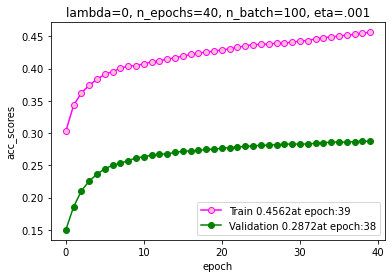

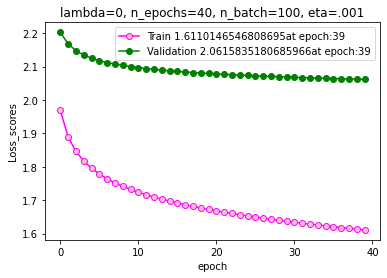

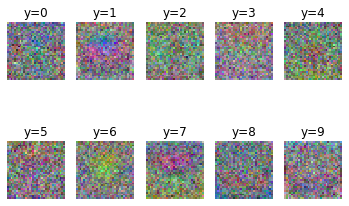

test accuracy at lambda=0, n_epochs=40, n_batch=100, eta=.001 :0.2941


In [466]:
plot_results(acc_scores1,Loss_scores1,acc_val_scores1,Loss_val_scores1,title1)
montage(w1)
test_accuracy(Xtest, ytest, w1, b1)

In [409]:
w2,b2,acc_scores2,Loss_scores2,acc_val_scores2,Loss_val_scores2=MiniBatchGD(X,Y,(100,0.1,40),W,b,0,y,Xval,yval,Yval)
title2='lambda=0, n_epochs=40, n_batch=100, eta=.1'


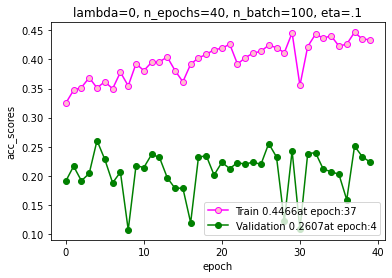

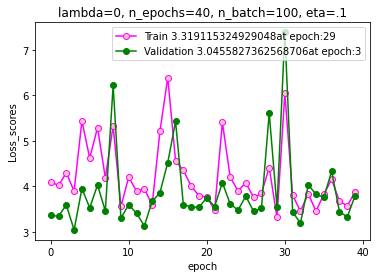

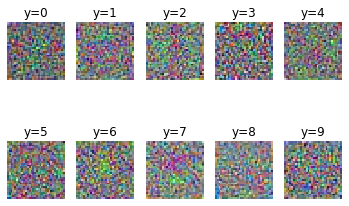

test accuracy at lambda=0, n_epochs=40, n_batch=100, eta=.001 :0.219


In [465]:
plot_results(acc_scores2,Loss_scores2,acc_val_scores2,Loss_val_scores2,title2)
montage(w2)
test_accuracy(Xtest, ytest, w2, b2)

In [347]:
w3,b3,acc_scores3,Loss_scores3,acc_val_scores3,Loss_val_scores3=MiniBatchGD(X,Y,(100,0.001,40),W,b,0.1,y,Xval,yval,Yval)
title3='lambda=0.1, n_epochs=40, n_batch=100, eta=.001'

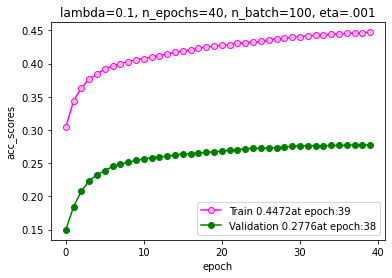

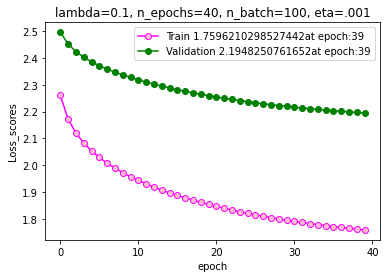

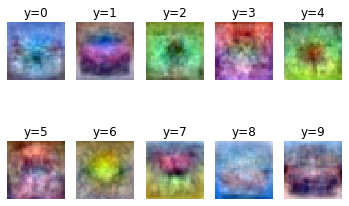

test accuracy at lambda=0, n_epochs=40, n_batch=100, eta=.001 :0.2223


In [464]:
plot_results(acc_scores3,Loss_scores3,acc_val_scores3,Loss_val_scores3,title3)
montage(w3)
test_accuracy(Xtest, ytest, w3, b3)

In [368]:
w4,b4,acc_scores4,Loss_scores4,acc_val_scores4,Loss_val_scores4=MiniBatchGD(X,Y,(100,0.001,40),W,b,1,y,Xval,yval,Yval)
title4='lambda=1, n_epochs=40, n_batch=100, eta=.001'

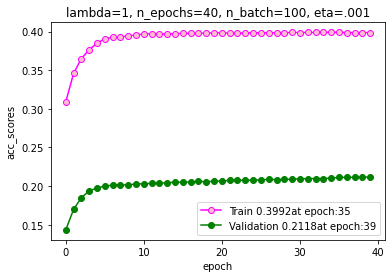

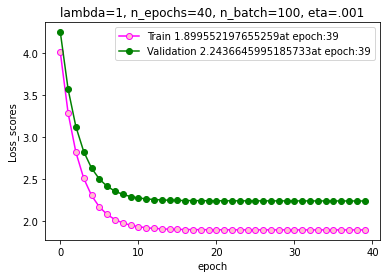

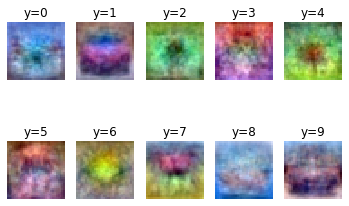

test accuracy at lambda=0, n_epochs=40, n_batch=100, eta=.001 :0.2144


In [462]:
plot_results(acc_scores4,Loss_scores4,acc_val_scores4,Loss_val_scores4,title4)
montage(w4)
test_accuracy(Xtest, ytest, w4, b4)